# EDA of bank marketing dataset

Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Note: Initial dataset was splitted on train and test sets by using stratified split on target ('y'). EDA is performed **only on training part**

In [1]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

from pandas_profiling import ProfileReport

import scipy
print('Scipy version:', scipy.__version__)

import statsmodels as sm
print('Statsmodels version:', sm.__version__)

import phik
from phik.report import plot_correlation_matrix

from sklearn.impute import SimpleImputer, KNNImputer

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1
Scipy version: 1.9.3
Statsmodels version: 0.13.5


In [2]:
"""
import logging
import sys

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

handler = logging.StreamHandler(stream=sys.stdout)
handler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(funcName)s: %(levelname)s] %(message)s'))
logger.addHandler(handler)
"""

"\nimport logging\nimport sys\n\nlogger = logging.getLogger()\nlogger.setLevel(logging.DEBUG)\n\nhandler = logging.StreamHandler(stream=sys.stdout)\nhandler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(funcName)s: %(levelname)s] %(message)s'))\nlogger.addHandler(handler)\n"

In [3]:
# SETTINGS
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
#pd.set_option('display.float_format',  '{:`}'.format)
sns.set_palette('pastel')

In [4]:
import_filename = 'datasets/bank-train.csv'
df = pd.read_csv(import_filename)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,152,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,158,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,214,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,24,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
4,25,services,single,high.school,no,no,no,cellular,may,thu,646,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp.var.rate    28831 non-null  float64
 16  cons.price.idx  28831 non-null  float64
 17  cons.conf.idx   28831 non-null 

### 0. Overall analysis and first insights

In [6]:
skip_profiling = True
#profile = None
#if not skip_profiling:
profile = ProfileReport(df, title='Preliminary EDA') if not skip_profiling else None
profile

Some insights and things to explore and clarify based on report above:  
1. 7 duplicate rows - find them out and try to determine if it's error or coincidence due to depersonalization
2. (1) in bank sphere the presence of credit in default status usually is considered as a stop-factor for banking service, (2) there are no rows with `y` == 'yes' AND `default` == 'yes', (3) among 'unknown' observations there are some with `y` == 'yes', but it doesn't contain any useful info for model, (4) imputing will most probably use most frequent value ('no'), so in this way `default` isn't useful for model too => feature can be probably dropped safely, but it needs check up
3. correlations between features check is necessary  
4. `loan` and `housing` features have 707 possibly shared records with 'unknown' value -> explore how to deal with them
5. `contact` feature can be one-hot encoded with 1 column (check if this feature contains useful info for model)
6. **Assumption**: `month` contains only 10 values (Jan and Feb are absent) with modal value 'May'. According to data description observations refer to period from May 2008 to November 2010 and ARE ORDERED BY DATE => we can try to restore month-year values based on the months order (CHECK FULL DATASET (1) for Jan and Feb values, (2) if restore data then in both datasets) + we can use months after 2008 year's financial crisis as a new feature  
**Conclusion**: (1) the whole dataset doesn't have 'jan' and 'feb' values as well, (2) `months_since_2018` will not be useful for prediction as all new instances are guaranteed to be further in time (extrapolation task). In case of interpolation task this feature could be useful
7. `day_of_week` feature have almost equal distribution and can be dropped (if useless will be proved)
8. `campaign` feature should be cutted based on 1.5*IQR (calculate threshold value)
9. Explore `pdays`, `previous`, `poutcome` features:
    - `pdays` contains hidden NAN value (999) in 96% of records => check if can be dropped (+ explore correlation with `previous` and `poutcome` features)
    - `previous` feature contains zeros in 86% of records => check if can be dropped (+ explore correlation with `pdays` and `poutcome` features)
    - `poutcome` feature contains 'nonexistent' value in 86% of records (probably the same where `previous` == 0) 
10. Impute real missing values left
11. (!!!) dataset is HIGHLY IMBALANCED => we have to be careful if dropping rows. Have to OVERSAMPLE positive rows before training model OR use weight options

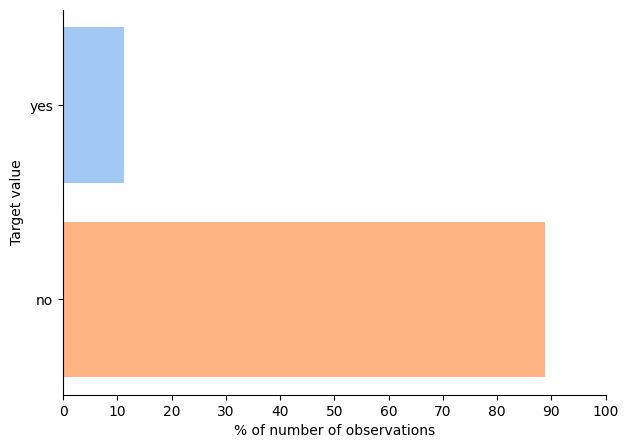

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
#sns.countplot(data=df, y='y', order=['yes', 'no'])
#ax = plt.gca()
ax.barh(y=df['y'].value_counts(normalize=True).index, width=df['y'].value_counts(normalize=True).values, color=[sns.color_palette('pastel')[1], sns.color_palette('pastel')[0]])
ax.set_ylabel('Target value')
ax.set_xlabel('% of number of observations')
ax.set_xticks(np.arange(0.0, 1.1, 0.1))
ax.set_xticklabels([int(x*100) for x in np.arange(00.0, 1.1, 0.1)])
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False)

In [8]:
# checking real number of missing values left
cat_nan_equiv = 'unknown'
num_nan_equiv = 999
real_nans = {}
print(f'Calculating real NaNs ratio using `{cat_nan_equiv}` and `{num_nan_equiv}` keyvalues:')
print('Column (value) \tNvalues \tRatio')
print('-'*40)
for col in df.columns:
    if df[col].dtype == 'object':
        nan_equiv = cat_nan_equiv
    else:
        nan_equiv = num_nan_equiv
    if nan_equiv in list(df[col]):
        freq_table = df[col].value_counts()
        real_nans[col] = [freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)]
        print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


[]

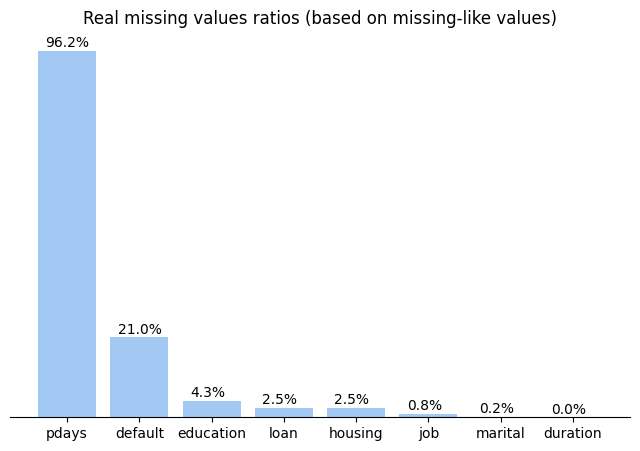

In [9]:
x = []
y = []
for col, val in real_nans.items():
    x.append(col)
    y.append(val[1])
x = [i for _, i in sorted(zip(y, x), key=lambda pair: pair[0])[::-1]]
y = sorted(y)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(x=x, height=y, color=sns.color_palette()[0])
for a_x, a_val in enumerate(y):
    ax.annotate('{:.1f}%'.format(a_val), xy=(a_x-0.3, a_val+1))
ax.set_title('Real missing values ratios (based on missing-like values)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])

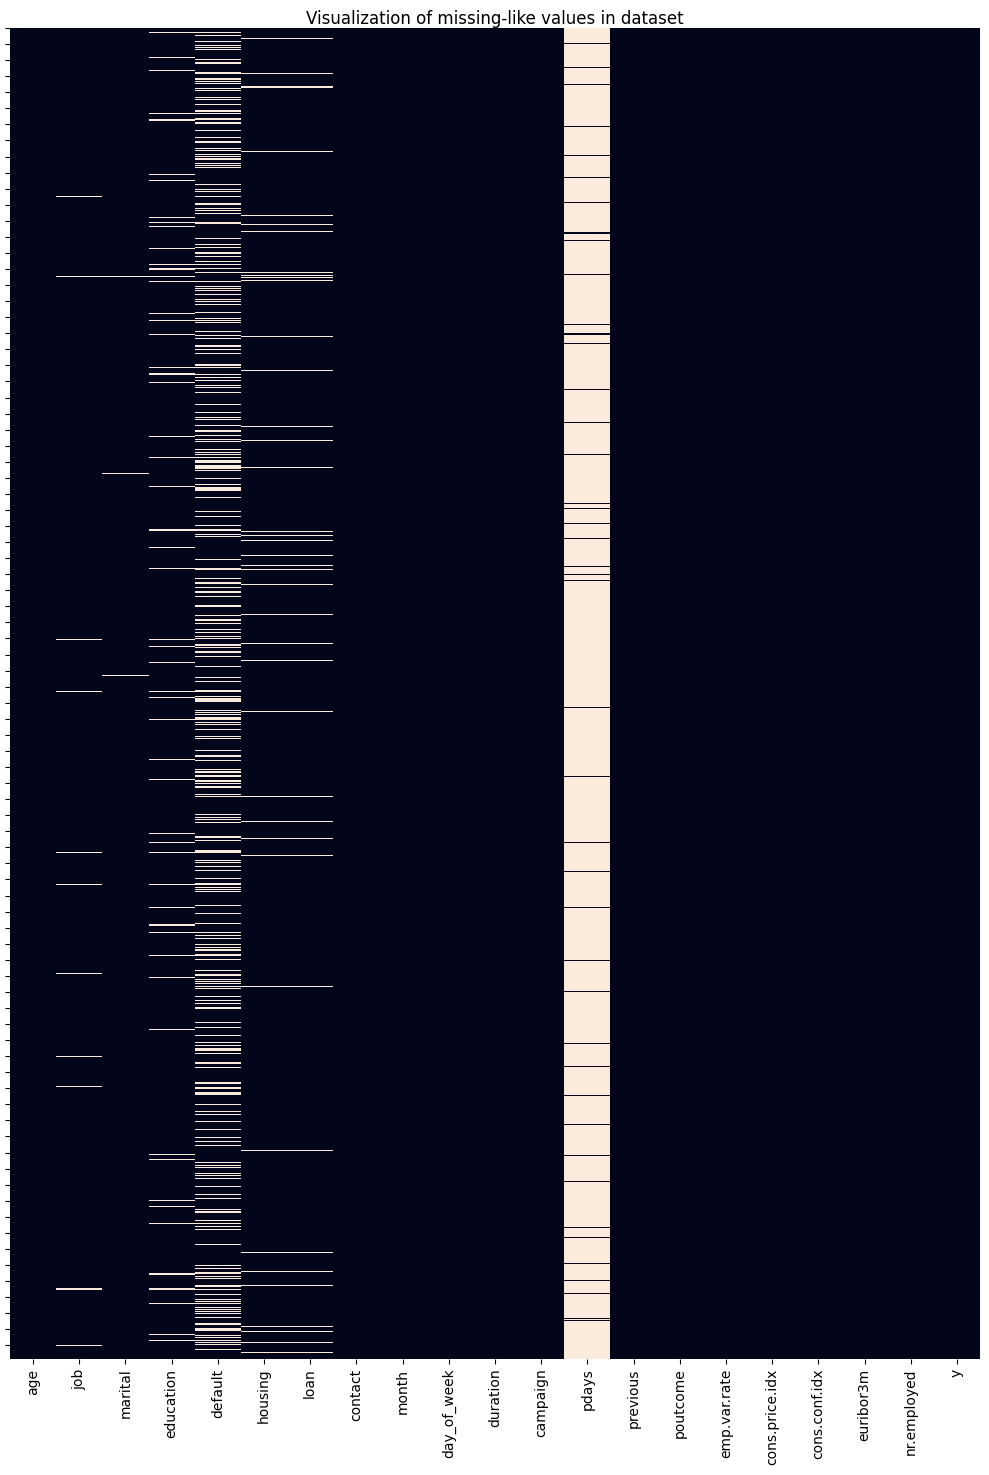

In [10]:
# ~(df.ne(999) & df.ne('unknown')) => df.ne() marks as True all "cells" which are not equal to given value
# df.ne() & df.ne() performs a "cell"-wise AND operator on 2 dataframes (which already contain True/False values only)
# and marks True only cells which are not equals neither first .ne() nor the second one
# Negate operator (~) inverses values to make False->True and thus converting them to 1 to display in heatmap
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
sns.heatmap(~(df.ne(999) & df.ne('unknown')), ax=ax, cbar=False)
ax.set_yticklabels([None]*len(ax.get_yticklabels()))
fig.suptitle('Visualization of missing-like values in dataset')
fig.tight_layout();

`pdays` feature has the maximum ratio of missing-like values (999) but it indicates that clients were not contacted on previous marketing campaign

In [11]:
# replacing string values in target with integers to ease further analysis
target_positive = 1
target_negative = 0
df['y'] = df['y'].map({'yes': target_positive, 'no': target_negative})
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,152,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,158,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,0
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,214,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,24,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0
4,25,services,single,high.school,no,no,no,cellular,may,thu,646,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,1


Implementation of function calculating Weight-of-Evidence (WoE, can be used as a replacer value when encoding categorical columns) and Information Value (can be used as feature's predictive power measure) for categorical columns  
Encode possible values using Weight-of-Evidence (WoE) and/or Information Value (IV) approach  
$ WoE = \ln(\frac{EventShare}{NonEventShare}) $  
$ IV = \sum{(EventShare-NonEventShare)*WoE} $

In [12]:
# (OLD, NOT USED) slower version using pandas dataframe
def get_woe_cat_df(X, y, return_details=False):
    num_events_total = y.sum()
    num_nonevents_total = len(y) - num_events_total
    grouper = pd.DataFrame({'feature': X, 'target': y}).groupby('feature')
    woe = pd.DataFrame({'num_events': grouper['target'].sum(), 'num_nonevents': grouper['target'].count() - grouper['target'].sum(), 'num_total': grouper['target'].count()})
    woe['events_share'] = woe['num_events'] / num_events_total
    woe['nonevents_share'] = woe['num_nonevents'] / num_nonevents_total
    woe['woe'] = np.log(woe['events_share'] / woe['nonevents_share'])
    woe['iv'] = (woe['events_share'] - woe['nonevents_share']) * woe['woe']
    if return_details:
        return (woe, woe['iv'].sum())
    else:
        return (woe['woe'], woe['iv'].sum())


In [13]:
# faster (almost 40% faster) version based on numpy arrays
def get_woe_cat(X, y, return_details=False):
    # a = a[a[:, 0].argsort()] # sort by 1st column
    # np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:]) # return grouped values
    num_events_total = y.sum()
    num_nonevents_total = len(y) - num_events_total
    grouper = pd.DataFrame({'feature': X, 'target': y}).groupby('feature', as_index=True)

    num_total = grouper['target'].count().to_numpy()
    num_events = grouper['target'].sum().to_numpy()
    index = grouper['target'].sum().index
    
    num_nonevents = num_total - num_events
    events_share = num_events / num_events_total
    nonevents_share = num_nonevents / num_nonevents_total
    woe = np.log((events_share+0.001) / (nonevents_share+0.001)) # adding small value to nominator and denominator to exclude division by 0 error
    iv = (events_share - nonevents_share) * woe
    
    if return_details:
        return (
            pd.DataFrame({
                    'num_events': num_events, 
                    'num_nonevents': num_nonevents,
                    'num_cat_total': num_total, 
                    'events_share': events_share, 
                    'nonevents_share': nonevents_share, 
                    'woe': woe, 
                    'iv': iv
                }, 
                index = index
            ),
            iv.sum()
        )
    else:
        return (pd.Series(woe, index=index, name='woe'), iv.sum())


In [14]:
print('Calculating prediction strength of features:')
print('Feature \tInformation Value')
print('-'*25)
ivs = []
cols = []
for col in df.select_dtypes(include='object').columns.difference(other=['y']):
    (woe, iv) = get_woe_cat(df[col], df['y'])
    print('{:12} \t{:.4f}'.format(col, iv))
    cols.append(col)
    ivs.append(iv)
idxs = np.argsort(np.array(ivs))
cols = np.array(cols)[idxs][::-1]
ivs = np.array(ivs)[idxs][::-1]

Calculating prediction strength of features:
Feature 	Information Value
-------------------------
contact      	0.2425
day_of_week  	0.0034
default      	0.1220
education    	0.0509
housing      	0.0006
job          	0.1740
loan         	0.0000
marital      	0.0307
month        	0.4527
poutcome     	0.5355


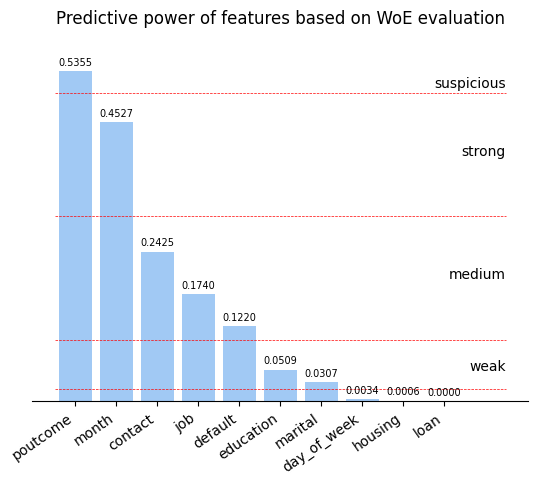

In [15]:
plt.bar(x=cols, height=ivs)
plt.plot([-0.5, len(ivs)+0.5], [0.02, 0.02], 'r--', lw=0.5)
plt.plot([-0.5, len(ivs)+0.5], [0.1, 0.1], 'r--', lw=0.5)
plt.plot([-0.5, len(ivs)+0.5], [0.3, 0.3], 'r--', lw=0.5)
plt.plot([-0.5, len(ivs)+0.5], [0.5, 0.5], 'r--', lw=0.5)
plt.annotate('weak', xy=(len(ivs)+0.5,0.05), ha='right')
plt.annotate('medium', xy=(len(ivs)+0.5,0.2), ha='right')
plt.annotate('strong', xy=(len(ivs)+0.5,0.4), ha='right')
plt.annotate('suspicious', xy=(len(ivs)+0.5,0.51), ha='right')
ax = plt.gca()
for a_x, a_val in enumerate(ivs):
    plt.annotate('{:.4f}'.format(a_val), xy=(a_x-0.4, a_val+0.01), fontsize=7)
plt.xticks(rotation=35, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_ybound(upper=0.6)
plt.title('Predictive power of features based on WoE evaluation');

According to [web info](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/) there are following ranges to determine predictive power of feature:  
  
| Information Value | Predictive power  |
| --- | --- |    
| <0.02             | Useless           |  
| 0.02 to 0.1       | Weak predictors   |  
| 0.1 to 0.3        | Medium Predictors |  
| 0.3 to 0.5        | Strong predictors |  
| >0.5              | Suspicious        |  

In [16]:
def interpret_iv(iv):
    if iv < 0.02:
        return 'useless'
    elif iv >= 0.02 and iv < 0.1:
        return 'weak'
    elif iv >=0.1 and iv < 0.3:
        return 'medium'
    elif iv >= 0.3 and iv < 0.5:
        return 'strong'
    else:
        return 'suspicious'

### 1. Duplicated rows

In [17]:
# search and display by mask
m = df.duplicated(keep=False)
df.loc[m, :]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
595,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0
1309,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0
3095,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0
4657,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8702,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
10205,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0
13216,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
15353,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0
18168,71,retired,single,university.degree,no,no,no,telephone,oct,tue,120,1,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0
21658,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0


[ASSUMPTION] We've lost the initial order of records when splitted dataset on training and testing parts. And now we can't verify that duplicated records are related to different years => different people. So we assume that duplicated records mean different observations and are not errors in dataset

### 2. `default` feature

Reminder: (1) in bank sphere the presence of credit in default status usually is considered as a stop-factor for banking service, (2) there are no rows with y == 'yes' AND default == 'yes', (3) among 'unknown' observations there are some with y == 'yes', but it doesn't contain any useful info for model, (4) imputing will most probably use most frequent value ('no'), so in this way `default` isn't useful for model too => feature can be dropped safely

But Information Value indicator shows that `default` has medium predictive power. So it's better to leave it for now and test model accuracy later with and without this feature

In [18]:
woe, iv = get_woe_cat(df['default'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.1220 (medium)


feature
no         0.1503
unknown   -0.8191
yes       -0.1109
Name: woe, dtype: float64

In [19]:
# encoding by WoE values
df['default'] = df['default'].map(dict(zip(woe.index, woe.values)))
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
26320,53,admin.,married,high.school,0.1503,yes,no,cellular,may,fri,45,1,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,0
7829,36,entrepreneur,single,university.degree,0.1503,yes,no,cellular,nov,wed,911,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,1
18257,29,technician,single,university.degree,0.1503,no,no,cellular,jul,wed,159,6,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,0
2445,33,technician,single,university.degree,0.1503,no,yes,telephone,may,wed,130,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
23488,46,unemployed,married,basic.9y,0.1503,unknown,unknown,cellular,jun,tue,96,1,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,0


[PIPELINE] This step should appear in preprocessing pipeline

### 3. Check correlations between features

In [20]:
personal_columns = list(df.columns[:4])+list(df.columns[5:7]) # exclude 'default' feature
print(personal_columns)

['age', 'job', 'marital', 'education', 'housing', 'loan']


Correlation also can help to suppose values to use in imputing process

We have numeric features only in 'Previous Campaign Results' (features 9-12) and 'Socioeconomic Indicators' (features 14-18) sections (not saying about age).  
Obviously 'Socioeconomic Indicators' don't have a causal relations with individual characteristics even if correlation is high. So we will not analyse these cross-section values.  
But we would like to test some relations between 'Individual Characteristics' section's features:
- is there any relation between:
    - age and job?
    - age and marital?
    - job and edication?
- are any of individual characteristics in relation with presence / absence of loans? 

In [21]:
# use phi_k coefficient to measure degree of association
phik_overview = df[list(personal_columns)+['y']].phik_matrix(interval_cols=['age'])
phik_overview

,age,job,marital,education,housing,loan,y
age,1.0000,0.5165,0.4185,0.2403,0.0000,0.0000,0.2222
job,0.5165,1.0000,0.3815,0.6733,0.0284,0.0226,0.1883
marital,0.4185,0.3815,1.0000,0.2572,0.0131,0.0000,0.0853
education,0.2403,0.6733,0.2572,1.0000,0.0253,0.0000,0.0916
housing,0.0000,0.0284,0.0131,0.0253,1.0000,0.9432,0.0000
loan,0.0000,0.0226,0.0000,0.0000,0.9432,1.0000,0.0000
y,0.2222,0.1883,0.0853,0.0916,0.0000,0.0000,1.0000


<AxesSubplot: >

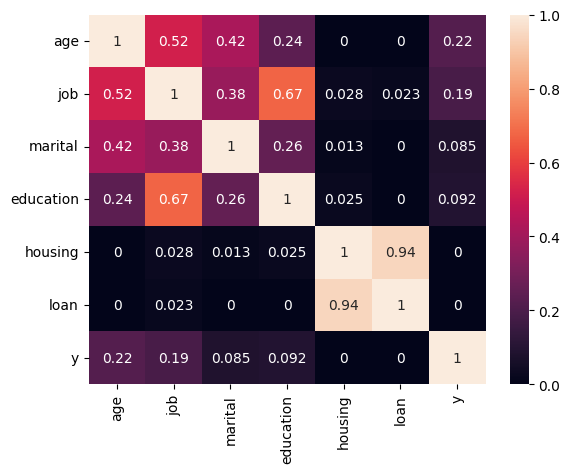

In [22]:
sns.heatmap(phik_overview, annot=True)

There are no features that highly correllated with target ('y')  
We have 3 relatively strong associations: (1) between education and job (0.67), (2) between job and age (0.52) and (3) marital and age (0.42)  
We can experiment with excluding one of these features from dataset when training model  

Let's show the association between education and job

In [23]:
# converting `education` column to ordered categorical type to get ordered chart output
education_ordered = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
df['education_ordered'] = pd.Categorical(df['education'], education_ordered, ordered=True)
df['education_ordered']

0                   basic.4y
1        professional.course
2        professional.course
3          university.degree
4                high.school
                ...         
28826    professional.course
28827      university.degree
28828      university.degree
28829               basic.4y
28830            high.school
Name: education_ordered, Length: 28831, dtype: category
Categories (8, object): ['unknown' < 'illiterate' < 'basic.4y' < 'basic.6y' < 'basic.9y' < 'high.school' < 'professional.course' < 'university.degree']

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_17332\3322450664.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[t.get_text() for t in ax.get_xticklabels()], ha='right', rotation=35);


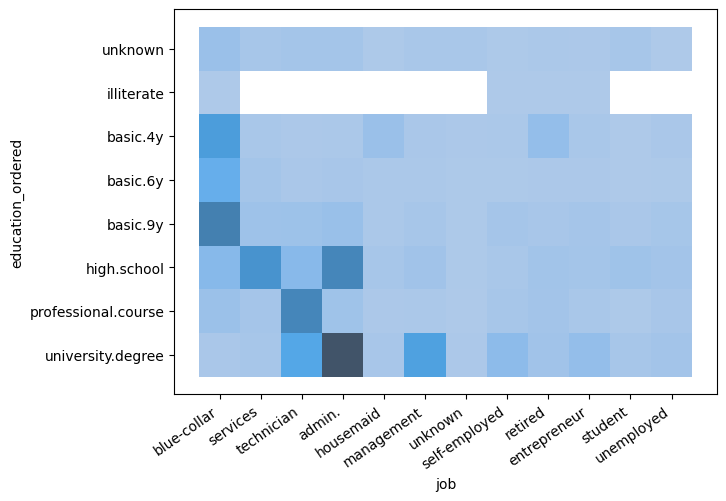

In [24]:
# building 2-axis histogram (like heatmap)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data=df, x='job', y='education_ordered', ax=ax)
ax.set_xticklabels(labels=[t.get_text() for t in ax.get_xticklabels()], ha='right', rotation=35);

Let's check age distribution for other categorical features values to possibly gain some insights

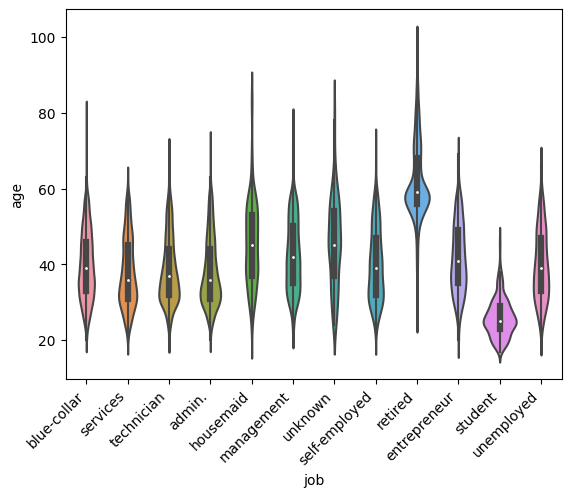

In [25]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.violinplot(data=df, x='job', y='age')
plt.xticks(rotation=45, ha='right');

As expected 'retired' and 'student' classes distributions are shifted. But for others there is nothing unusual

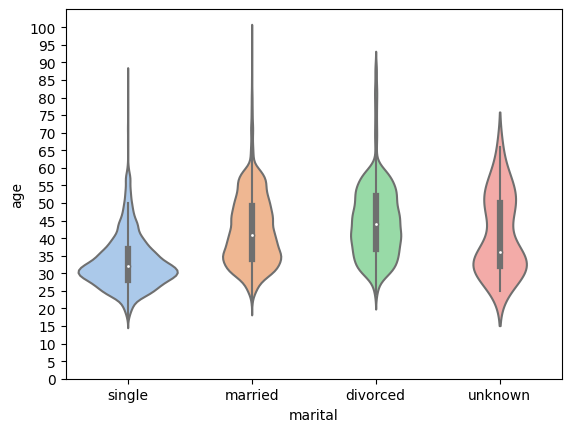

In [26]:
sns.violinplot(data=df, x='marital', y='age')
plt.yticks(range(0, 105, 5));

'unknown' value's distribution is multimodal. 1st mode is near equivalent of 'single' value's distribution one

C:\Users\Дмитрий\AppData\Local\Temp\ipykernel_17332\3352124867.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.displot(data=df[df['marital'] != cat_nan_equiv], x='age', hue='marital', kind='kde', palette=sns.color_palette('pastel'), fill=True);


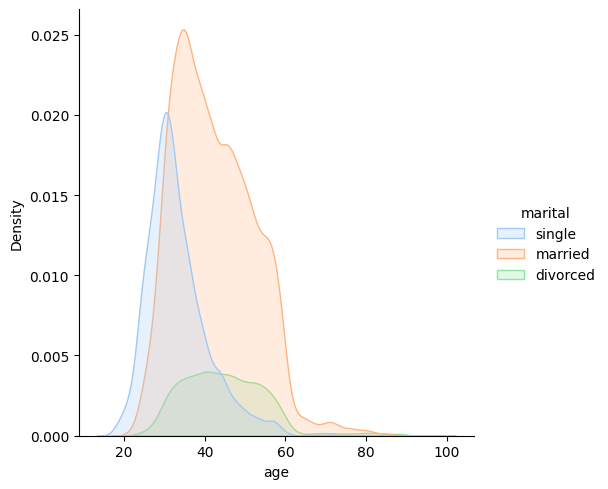

In [27]:
sns.displot(data=df[df['marital'] != cat_nan_equiv], x='age', hue='marital', kind='kde', palette=sns.color_palette('pastel'), fill=True);

For analyzed pairs we can impute values based on corresponding features:  
[PIPELINE]  
(!!!) Age should be binned  
Option 1:  
1. Use KNN-imputing / Simple imputing  
  
Option 2:  
1. Impute job and education (strongest association) based on most frequent corresponding values
2. Impute job based on most frequent value for corresponding age bin
3. Impute marital status based on most frequent value for corresponding age bin
4. Impute NANs left using any strategy or model (KNNImputer?)

In [28]:
"""
Calculates most_frequent values of base_feat for each corresponding value of reference_feat
Both features have to be categorical. If reference_feat is numerical it is possible to split it to bins
and use function using bins instead of exact values 
Returns a dictionary with reference_value: base_value pairs made using most_frequent strategy
"""
def get_reference_values(df, base_feat, reference_feat, nan_equiv=np.nan):
    is_numeric = True
    try:
        np.float64(nan_equiv)
    except ValueError:
        is_numeric = False
    if is_numeric and np.isnan(nan_equiv):
        ct = pd.crosstab(df[base_feat], df[reference_feat]) # rows = values of base feature, cols = values of reference feature
    else:
        ct = pd.crosstab(df.loc[(df[base_feat] != nan_equiv), base_feat], df[reference_feat])
    index = ct.index
    columns = ct.columns
    return {columns[i]: index[val] for i, val in enumerate(ct.to_numpy().argmax(axis=0))}

Test for imputing education based on most frequent job

In [29]:
m = df['education'] == cat_nan_equiv
df.loc[m, ['education', 'job']]

,education,job
9,unknown,housemaid
19,unknown,blue-collar
28,unknown,housemaid
97,unknown,services
105,unknown,blue-collar
...,...,...
28684,unknown,admin.
28768,unknown,student
28794,unknown,technician
28797,unknown,blue-collar


In [30]:
df.loc[m, 'education'] = df.loc[m, 'job'].map(get_reference_values(df, 'education', 'job', nan_equiv='unknown'))

In [31]:
df.loc[m, ['education', 'job']]

,education,job
9,basic.4y,housemaid
19,basic.9y,blue-collar
28,basic.4y,housemaid
97,high.school,services
105,basic.9y,blue-collar
...,...,...
28684,university.degree,admin.
28768,high.school,student
28794,professional.course,technician
28797,basic.9y,blue-collar


Test for imputing job based on most frequent education

In [32]:
m = df['job'] == cat_nan_equiv
df.loc[m, ['job', 'education']]

,job,education
20,unknown,high.school
142,unknown,university.degree
274,unknown,basic.4y
325,unknown,basic.4y
367,unknown,high.school
...,...,...
28177,unknown,basic.4y
28381,unknown,basic.4y
28483,unknown,basic.4y
28540,unknown,high.school


In [33]:
df.loc[m, 'job'] = df.loc[m, 'education'].map(get_reference_values(df, base_feat='job', reference_feat='education', nan_equiv='unknown'))
df.loc[m, ['job', 'education']]

,job,education
20,admin.,high.school
142,admin.,university.degree
274,blue-collar,basic.4y
325,blue-collar,basic.4y
367,admin.,high.school
...,...,...
28177,blue-collar,basic.4y
28381,blue-collar,basic.4y
28483,blue-collar,basic.4y
28540,admin.,high.school


To impute marital status based on age it's necessary to split age feature to bins

<AxesSubplot: xlabel='age', ylabel='Count'>

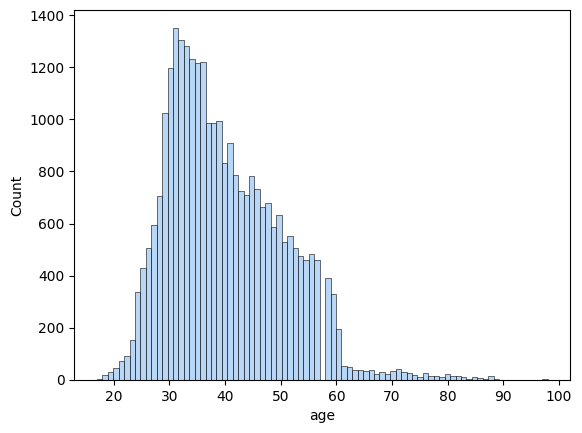

In [34]:
sns.histplot(data=df, x='age')

In [35]:
print('Age feature characteristics:')
print('Mean     \t{:.0f}'.format(df['age'].mean()))
print('Median   \t{:.0f}'.format(df['age'].median()))
print('Mode     \t{:.0f}'.format(df['age'].mode().iloc[0]))
print('Skewness \t{:.2f}'.format(df['age'].skew()))
print('Kurtosis \t{:.2f}'.format(df['age'].kurt()))

Age feature characteristics:
Mean     	40
Median   	38
Mode     	31
Skewness 	0.76
Kurtosis 	0.65


In [36]:
# splitting age to bins
# equal bins defined by total number
#bins = 10
bins = pd.IntervalIndex.from_breaks(np.arange(15, 100, 10))
df['age_bins'] = pd.cut(df['age'], bins=bins)

In [37]:
bins.mid

Float64Index([20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0], dtype='float64')

In [38]:
age_grouper = df.groupby('age_bins')
age_grouper['age'].count() * 100 / len(df)

age_bins
(15, 25]     4.0789
(25, 35]    36.1243
(35, 45]    30.9736
(45, 55]    20.1762
(55, 65]     7.1659
(65, 75]     0.9191
(75, 85]     0.4821
(85, 95]     0.0763
Name: age, dtype: float64

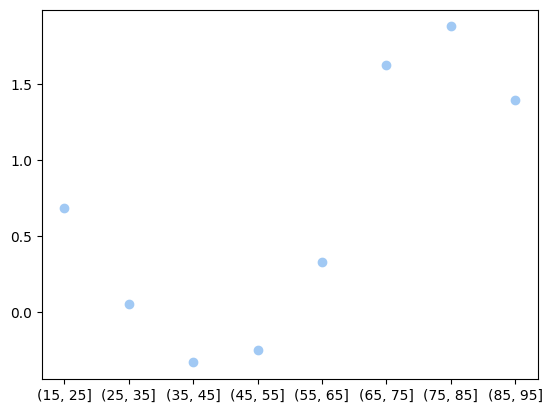

In [39]:
woe, iv = get_woe_cat(df['age_bins'], df['y'])
plt.scatter(x=woe.index.codes, y=woe.values)
plt.xticks(ticks=woe.index.codes, labels=woe.index);

In [40]:
# imputation for marital
m = df['marital'] == cat_nan_equiv
smp_marital = SimpleImputer(missing_values=cat_nan_equiv, strategy='most_frequent')
df['marital'] = smp_marital.fit_transform(df['marital'].to_numpy().reshape(-1, 1))
df.loc[m, 'marital'].value_counts()

married    58
Name: marital, dtype: int64

<AxesSubplot: >

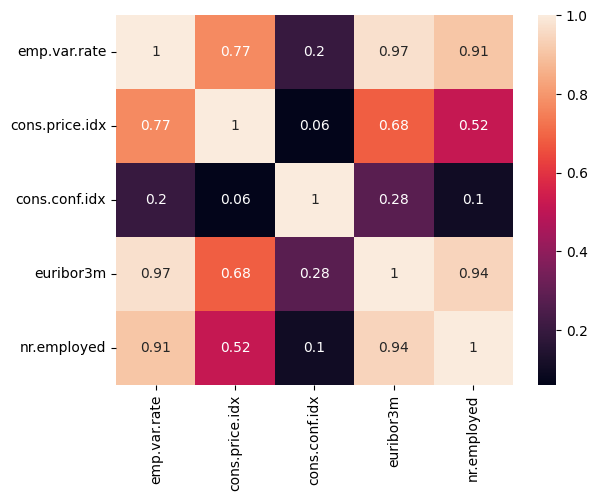

In [41]:
# check the correlation between socioeconomic features
soc_econ_features = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
m_corr = df[soc_econ_features].corr()
sns.heatmap(m_corr, annot=True)

We have highly correlated features. This might be a problem for some ML models. Possibly we will have to drop some of them depending on the chosen model.

[PIPELINE]
1. Possibly drop one or more soc_econ columns due to high correlation (test what columns are more important to model)

### 4. `loan` and `housing` features

Although these features are considered useless we will keep them for now and see if they really will not help model to predict

In [42]:
pd.crosstab(df['loan'].fillna('missing'), df['housing'].fillna('missing'), margins=True)

housing,no,unknown,yes,All
loan,,,,
no,11208,0,12493,23701
unknown,0,707,0,707
yes,1805,0,2618,4423
All,13013,707,15111,28831


These 707 'unknown' values are shared indeed. These features may correspond with age (housing loans might be paid off by elders) / job (due to bank's processes of credit scoring) / education / marital status

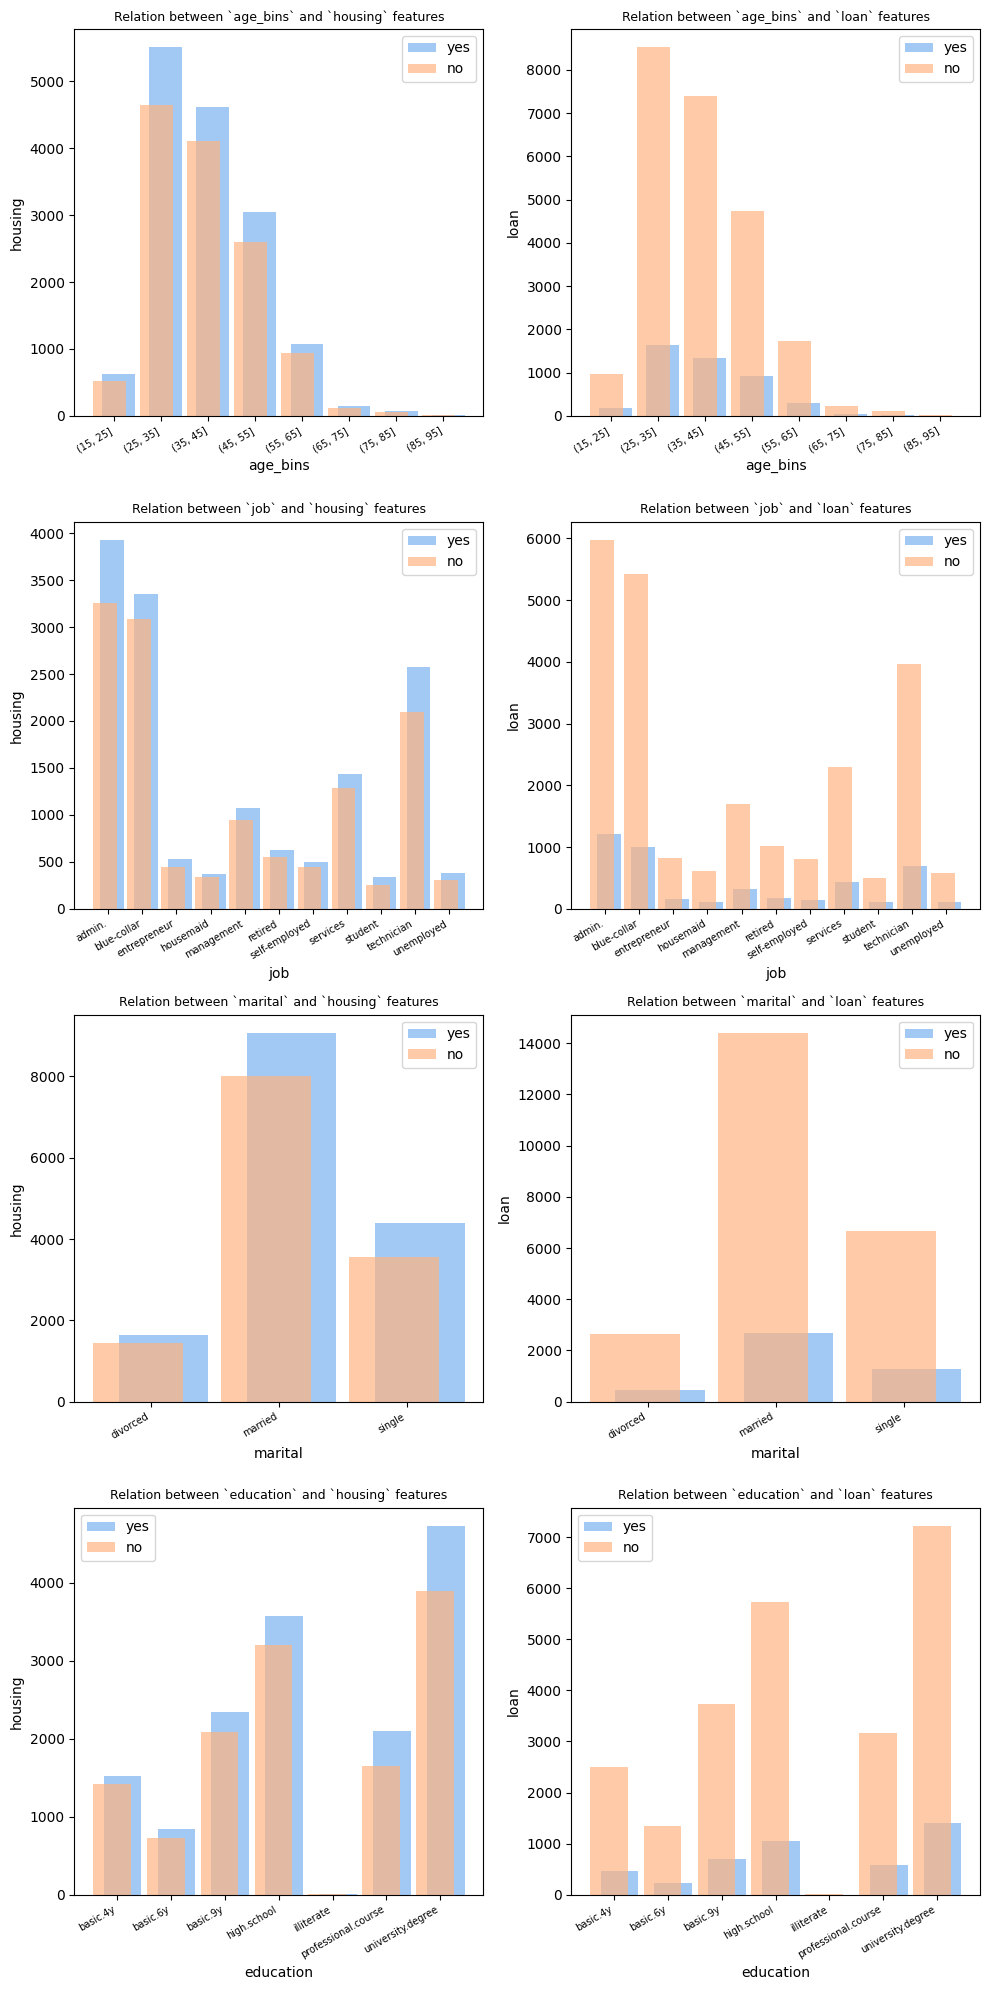

In [43]:
x_features = ['age_bins', 'age_bins', 'job', 'job', 'marital', 'marital', 'education', 'education']
y_features = ['housing', 'loan', 'housing', 'loan', 'housing', 'loan', 'housing', 'loan']

chart_rows, charts_per_row = 4, 2
sns.set_palette('pastel')
fig, axs = plt.subplots(chart_rows, charts_per_row, figsize=(5*charts_per_row,  5*chart_rows))

for ax, x_feature, y_feature in zip(axs.flatten(), x_features, y_features):
    ct = pd.crosstab(df[x_feature], df[y_feature])

    ax.bar(x=[x+0.1 for x in range(len(ct))], height=ct['yes'], width=0.7, label='yes')
    ax.bar(x=[x-0.1 for x in range(len(ct))], height=ct['no'], width=0.7, alpha=0.7, label='no')
    ax.set_xticks(range(len(ct)))
    ax.set_xticklabels([str(x) for x in ct.index], fontsize=7, rotation=30, ha='right')
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.legend()
    ax.set_title(f'Relation between `{x_feature}` and `{y_feature}` features', fontsize=9)
plt.tight_layout();

[PIPELINE]  
Option 1: Impute missing values using following default values: 'yes' for `housing` feature and 'no' for `loan` feature as these values are observed across all individual features  
Option 2: Replace values in feature by WoE values using 'unknown' values as separate group

In [44]:
# option 1
feat = 'housing'
m = (df[feat] == 'unknown') # boolean mask to filter rows
df.loc[m, feat].value_counts()

unknown    707
Name: housing, dtype: int64

In [45]:
df.loc[m, feat] = 'yes'
df.loc[m, feat].value_counts()

yes    707
Name: housing, dtype: int64

Now we have all 'unknown' replaced with 'yes' in `housing`. Let's do the same for `loan` but with 'no' value

In [46]:
feat = 'loan'
m = (df[feat] == 'unknown') # boolean mask to filter rows
df.loc[m, feat] = 'no'
df.loc[m, feat].value_counts()

no    707
Name: loan, dtype: int64

### 5. `contact` feature


`contact` feature can be one-hot encoded with 1 column (check if this feature contains useful info for model)

In [47]:
df['contact'].value_counts(dropna=False)

cellular     18302
telephone    10529
Name: contact, dtype: int64

In [48]:
# converting to binary integer 'Cellular or not' 
df['contact'] = df['contact'].map({'cellular': 1.0, 'telephone': 0.0})
df['contact'].value_counts()

1.0    18302
0.0    10529
Name: contact, dtype: int64

[PIPELINE]  
Option 1: Convert `contact` feature to one-hot encoded form by replacing 'cellular' with 1.0 and 'telephone' with 0.0  
Option 2: Replace values to WoE estimates

### 6. Assumption checked (see 1_...ipynb and comment in cell 7 above)

### 7. `day_of_week` feature

In [49]:
woe, iv = get_woe_cat(df['day_of_week'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.0034 (useless)


feature
fri   -0.0149
mon   -0.1041
thu    0.0650
tue    0.0148
wed    0.0335
Name: woe, dtype: float64

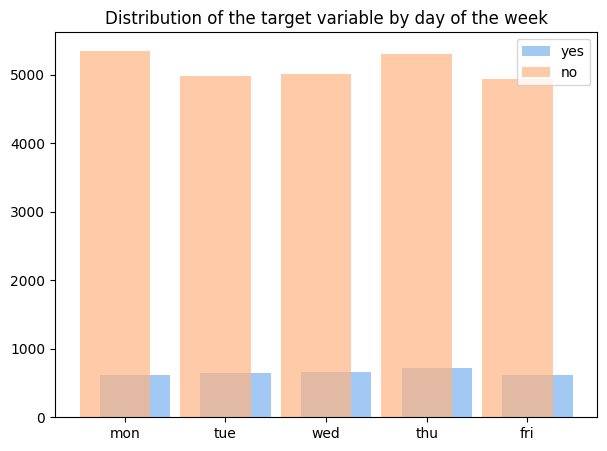

In [50]:
sorted_dow = ['mon', 'tue', 'wed', 'thu', 'fri']
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ct = pd.crosstab(df['day_of_week'], df['y'])
ax.bar(x=[x+0.1 for x in range(len(sorted_dow))], height=[ct.loc[x, target_positive] for x in sorted_dow], width=0.7, label='yes')
ax.bar(x=[x-0.1 for x in range(len(sorted_dow))], height=[ct.loc[x, target_negative] for x in sorted_dow], width=0.7, alpha=0.7, label='no')
ax.set_xticks(range(len(ct)))
ax.set_xticklabels(sorted_dow)
ax.set_title('Distribution of the target variable by day of the week')
ax.legend();

There are small variations between days but it will be better to test experimentally if this feature is useful for model  
  
[PIPELINE]  
Option 1: Map ['mon', 'tue', 'wed', 'thu', 'fri'] => [1, 2, 3, 4, 5]  
Option 2: Replace with WoE estimates

### 8. `campaign` feature

Reminder: `campaign` - number of contacts performed during this campaign and for this client (numeric, includes last contact)  
`campaign` feature skewed (long right tail) should be cutted based on 1.5*IQR

In [51]:
# check predictive power for initial feature based on WOE/IV
woe, iv = get_woe_cat(df['campaign'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))

Information Value: 0.0485 (weak)


In [52]:
df['campaign'].describe()

count    28831.0000
mean         2.5575
std          2.7531
min          1.0000
25%          1.0000
50%          2.0000
75%          3.0000
max         56.0000
Name: campaign, dtype: float64

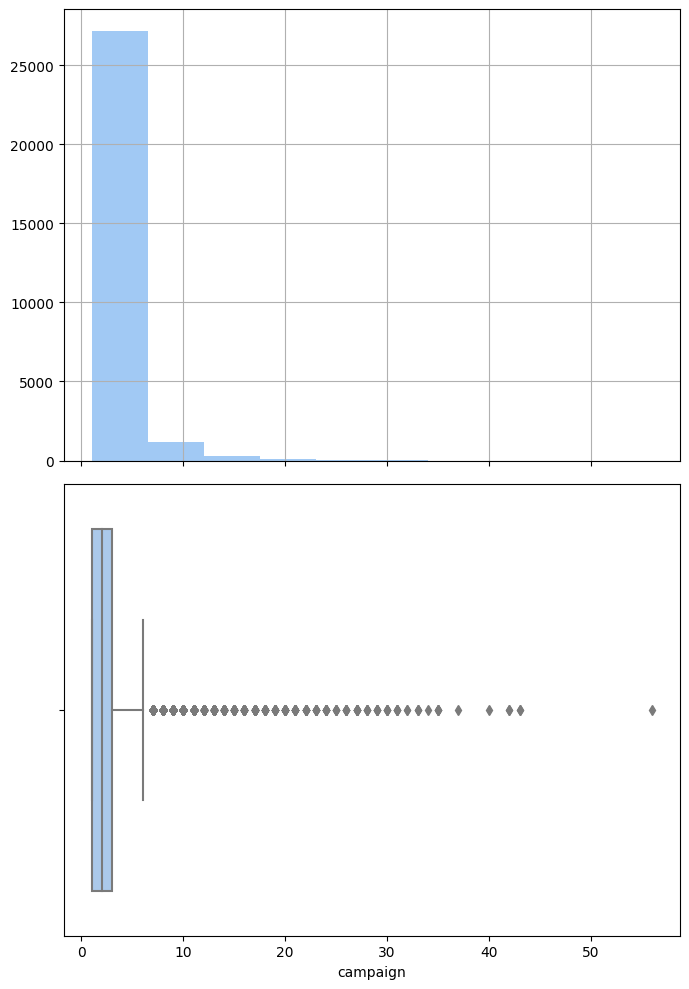

In [55]:
# check distribution
fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharex=True)
df['campaign'].hist(ax=axs[0])
# check distribution by boxplot + identifying outliers
sns.boxplot(data=df, x='campaign', ax=axs[1])
fig.tight_layout();

In [56]:
# consider outliers as values > Q3 + 1.5*IQR
q1 = df['campaign'].quantile(0.25)
q3 = df['campaign'].quantile(0.75)
iqr = q3 - q1
cutoff_val = q3 + 1.5 * iqr
print(f'Q1  = {q1}')
print(f'Q3  = {q3}')
print(f'IQR = {iqr}')
print(f'Cutoff value: {cutoff_val}')
# df[df['campaign'] > cutoff_val]['campaign'] # to show outliers

Q1  = 1.0
Q3  = 3.0
IQR = 2.0
Cutoff value: 6.0


yes/no ratio for `campaign` values
1.0: 0.147
2.0: 0.133
3.0: 0.122
4.0: 0.103
5.0: 0.078
6.0: 0.060


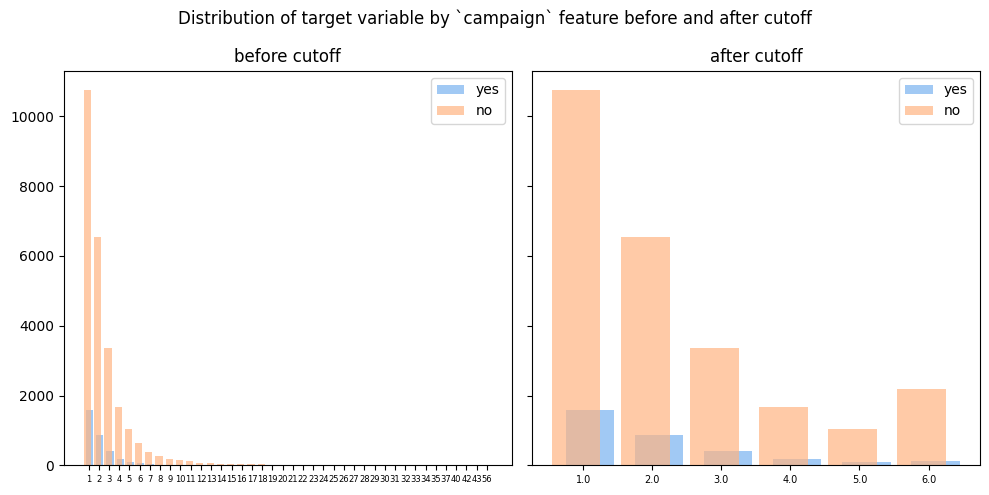

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ct = pd.crosstab(df['campaign'], df['y'])
ax[0].bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
ax[0].bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
ax[0].set_xticks(range(len(ct)))
ax[0].set_xticklabels(ct.index, fontsize=6)
ax[0].legend()
ax[0].set_title('before cutoff')

ct = pd.crosstab(df['campaign'].apply(lambda x: np.min([x, cutoff_val])), df['y'])
ax[1].bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
ax[1].bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
ax[1].set_xticks(range(len(ct)))
ax[1].set_xticklabels(ct.index, fontsize=7)
ax[1].legend()
ax[1].set_title('after cutoff')
fig.suptitle('Distribution of target variable by `campaign` feature before and after cutoff')
fig.tight_layout();
print('yes/no ratio for `campaign` values')
# yes / no values ratio for information
for x in ct.index:
    print('{}: {:.3f}'.format(x, ct.loc[x, 1]/ct.loc[x, 0]))

So in average the odds of opening deposit have negative relation with number of contacts

In [60]:
# performing real cutoff to dataset
df['campaign'] = df['campaign'].apply(lambda x: np.min([x, cutoff_val]))

In [61]:
# check predictive power for cutted feature based on WOE/IV
woe, iv = get_woe_cat(df['campaign'], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.0535 (weak)


feature
1.0    0.1455
2.0    0.0466
3.0   -0.0416
4.0   -0.2012
5.0   -0.4661
6.0   -0.7372
Name: woe, dtype: float64

<AxesSubplot: xlabel='feature', ylabel='woe'>

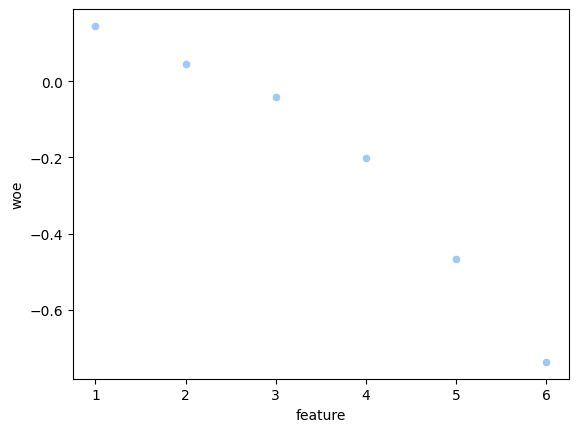

In [62]:
# check monotonity
sns.scatterplot(data=woe.reset_index(), x='feature', y='woe')

Here we see monotonic decreasing of WOE values which is necessary for prediction purpose. Predictive power of this `campaign` feature cutted-off to value 6 is weak but it still can be used for prediction  

[PIPELINE] In `campaign` feature replace outliers which a greater than 6 (Q3+1.5*IQR) with 6

### 9. Explore `pdays`, `previous`, `poutcome` features

Explore `pdays`, `previous`, `poutcome` features:
- `pdays` contains hidden NAN value (999) in 96% of records => can be dropped (+ explore correlation with `previous` and `poutcome` features)
- `previous` feature contains zeros in 86% of records => check if can be dropped (+ explore correlation with `pdays` and `poutcome` features)
- `poutcome` feature contains 'nonexistent' value in 86% of records (probably the same where `previous` == 0) 

Reminder:  
`pdays` - number of days that passed by after the client was last contacted from a previous campaign  
`previous` - number of contacts performed before this campaign and for this client (numeric)  
`poutcome` - outcome of the previous marketing campaign

#### 9.1. Exploring `pdays` feature

Information Value: 0.4711 (strong)


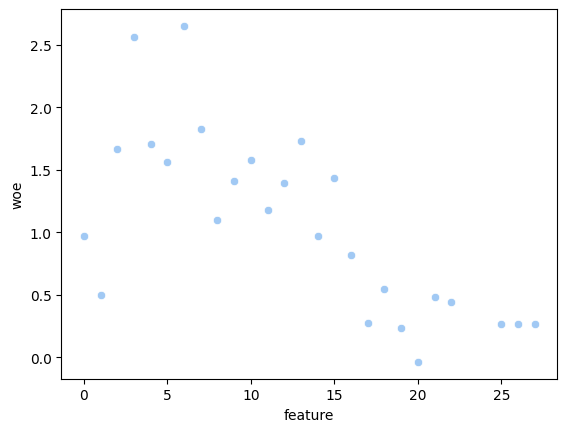

In [65]:
# check predictive power for initial feature based on WOE/IV
woe, iv = get_woe_cat(df['pdays'], df['y'])
sns.scatterplot(data=woe[woe.index < 999].reset_index(), x='feature', y='woe')
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))

There's no clear template in WoE values. But the feature is considered to have strong predictive power due to IV value

In [66]:
print('Absent-like values ratio: {:.2f}%'.format(df['pdays'].value_counts()[999] * 100 / len(df)))

Absent-like values ratio: 96.20%


In [67]:
pd.crosstab(df['y'], df['pdays'], margins=True)

pdays,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,25,26,27,999,All
y,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5,14,21,105,42,13,92,14,4,19,17,9,16,7,8,5,3,6,3,1,1,0,1,0,0,0,25177,25583
1,7,5,28,212,44,20,208,28,8,20,23,11,18,20,8,13,5,2,3,1,0,2,2,1,1,1,2557,3248
All,12,19,49,317,86,33,300,42,12,39,40,20,34,27,16,18,8,8,6,2,1,2,3,1,1,1,27734,28831


<AxesSubplot: xlabel='pdays'>

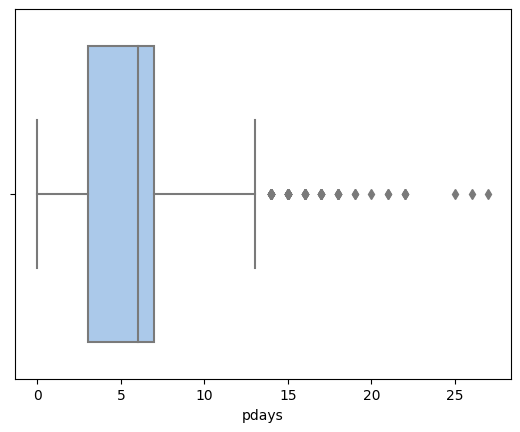

In [68]:
# boxplot of pdays to detect outlier values (excluding value 999)
sns.boxplot(data=df[df['pdays'] < 999], x='pdays')

In [69]:
# check what values are beyond Q3+1.5*IQR (except value 999)
q1 = df[df['pdays'] < 999]['pdays'].quantile(0.25)
q3 = df[df['pdays'] < 999]['pdays'].quantile(0.75)
iqr = q3 - q1
cutoff_val = q3 + 1.5 * iqr
print(f'Q1  = {q1}')
print(f'Q3  = {q3}')
print(f'IQR = {iqr}')
print(f'Cutoff value: {cutoff_val}')

Q1  = 3.0
Q3  = 7.0
IQR = 4.0
Cutoff value: 13.0


Information Value: 0.4421 (strong)


<AxesSubplot: xlabel='feature', ylabel='woe'>

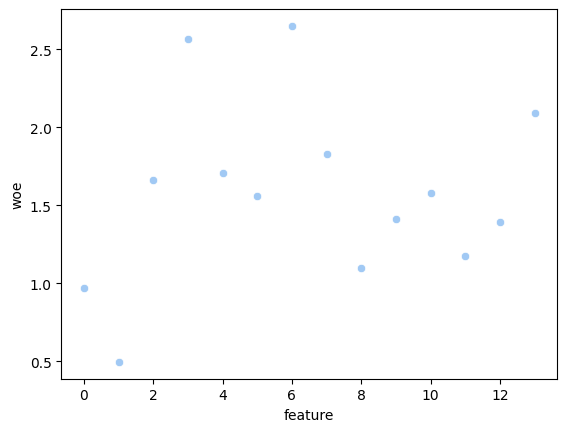

In [70]:
# check predictive power for cutted-off feature (excluded 999 value) based on WOE/IV
woe, iv = get_woe_cat(df[df['pdays'] < 999]['pdays'].apply(lambda x: np.min([13.0, x])), df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
sns.scatterplot(data=woe.reset_index(), x='feature', y='woe')

Further feature binning may be required

Seems in most cases if client was contacted in previous campaign the probability of positive decision is higher. Let's check it visually

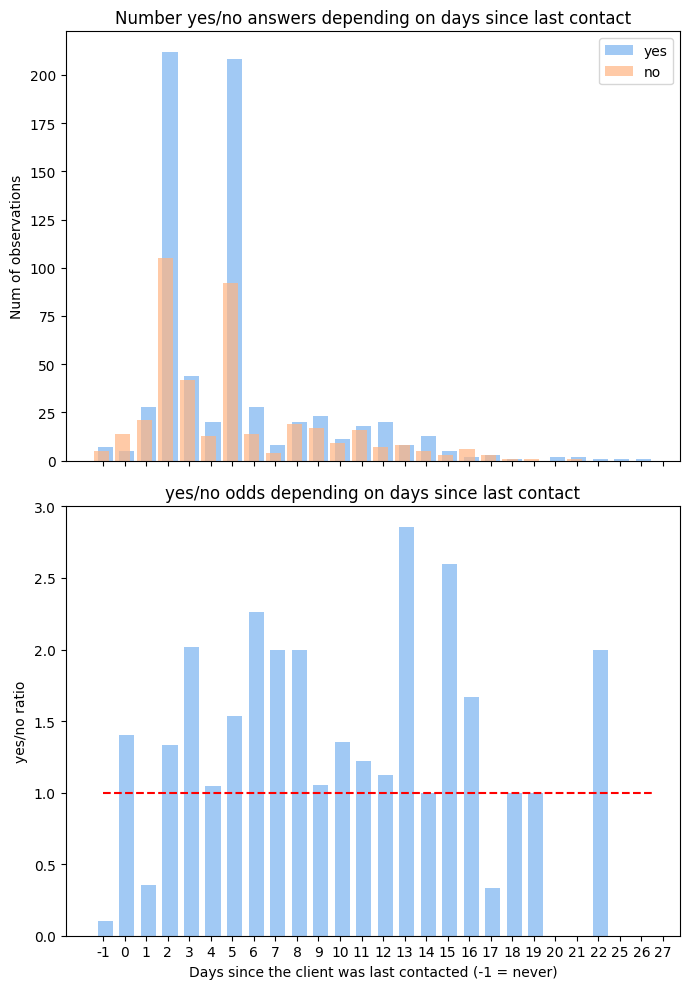

In [87]:
ct = pd.crosstab(df[df['pdays'] < 999]['pdays'], df['y']).sort_index(axis=0)
#ct.transpose()
fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharex=True)
axs[0].bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
axs[0].bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
axs[0].set_xticks(range(len(ct)))
axs[0].set_xticklabels(ct.index)
axs[0].set_ylabel('Num of observations')
axs[0].legend()
axs[0].set_title('Number of yes/no answers depending on days since last contact')

# replace 999 values with -1 to make more consistent scale
ct = pd.crosstab(df.replace({'pdays': {999: -1}})['pdays'], df['y']).sort_index(axis=0)
#ct.transpose()
#fig, ax = plt.subplots(1, 1, figsize=(7, 5))
axs[1].bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive]/ct[target_negative], width=0.7, label='yes/no odds')
#ax.bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
axs[1].plot([0, 25.5], [1.0, 1.0], 'r--')
axs[1].set_xticks(range(len(ct)))
axs[1].set_xticklabels(ct.index)
axs[1].set_xlabel('Days since the client was last contacted (-1 = never)')
axs[1].set_ylabel('yes/no ratio')
axs[1].set_title('yes/no odds depending on days since last contact')
#ax.legend();
fig.tight_layout();

We have 2 peaks here. Think in case of binning they should refer to different bins.  
The alternative is to binarize column (possibly as an additional feature?) by replacing 999 with 0 (not contacted before) and all other values with 1 (contacted before)  
[PIPELINE] Options to apply to `pdays` feature:  
1. Drop feature
2. Split values to bins considering values 3 and 6 as anchor points (base example: [0, 4), [4, 7), [7, 50), [50, 1000)) and apply WoE estimates  
3. Create additional feature `was_contacted`

Let's try to evaluate predictive power of binning from unit 2 above

In [67]:
# creating bins
pdays_bins = pd.IntervalIndex.from_breaks([-1, 3, 6, 13, 50, 999], closed='right')
pdays_bins

IntervalIndex([(-1, 3], (3, 6], (6, 13], (13, 50], (50, 999]], dtype='interval[int64, right]')

In [68]:
#creating new feature by applying bins
df['pdays_bin'] = pd.cut(df['pdays'], bins=pdays_bins)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_ordered,age_bins,pdays_bin
0,50,blue-collar,single,basic.4y,0.1503,no,no,0.0,may,thu,152,2.0,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0,basic.4y,"(45, 55]","(50, 999]"
1,51,services,married,professional.course,-0.8191,no,no,0.0,may,mon,158,5.0,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,0,professional.course,"(45, 55]","(50, 999]"
2,46,technician,divorced,professional.course,0.1503,yes,no,1.0,may,mon,214,2.0,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,0,professional.course,"(45, 55]","(50, 999]"
3,46,admin.,single,university.degree,0.1503,yes,no,0.0,jun,mon,24,1.0,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0,university.degree,"(45, 55]","(50, 999]"
4,25,services,single,high.school,0.1503,no,no,1.0,may,thu,646,5.0,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,1,high.school,"(15, 25]","(50, 999]"


In [69]:
# check predictive power for cutted-off feature based on WOE/IV
feature = 'pdays_bin'
woe, iv = get_woe_cat(df[feature], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.5189 (suspicious)


feature
(-1, 3]      2.4669
(3, 6]       2.5307
(6, 13]      2.2262
(13, 50]     1.8262
(50, 999]   -0.2230
Name: woe, dtype: float64

Received value of predictive power for this binning is suspiciously high. We'll have to check real predictive power when testing model

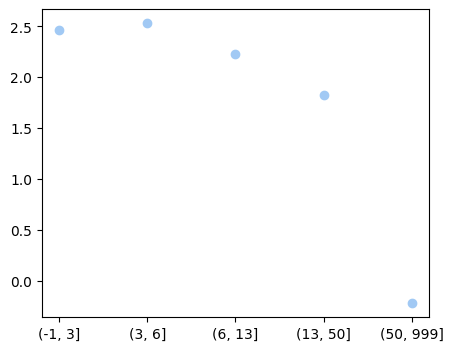

In [70]:
# check monotonity
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x=range(len(woe)), y=woe.values)
ax.set_xticks(range(len(woe)))
ax.set_xticklabels([str(x) for x in woe.index]);

In [71]:
# encoding by WoE values
df['pdays'] = df['pdays_bin'].map(dict(zip(woe.index, woe.values)))
df = df.drop(columns='pdays_bin')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_ordered,age_bins
21921,58,admin.,divorced,university.degree,0.1503,yes,no,0.0,aug,thu,688,6.0,-0.223,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,0,university.degree,"(55, 65]"
24495,50,blue-collar,married,basic.4y,-0.8191,no,no,1.0,may,thu,857,3.0,-0.223,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0,basic.4y,"(45, 55]"
14627,47,technician,single,university.degree,-0.8191,yes,yes,0.0,may,mon,118,6.0,-0.223,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,university.degree,"(45, 55]"
28812,55,management,divorced,basic.6y,-0.8191,yes,yes,1.0,jul,wed,124,2.0,-0.223,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,basic.6y,"(45, 55]"
22555,40,blue-collar,married,professional.course,0.1503,yes,no,1.0,jul,mon,96,3.0,-0.223,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,professional.course,"(35, 45]"


#### 9.2. Exploring `previous` feature

In [72]:
print('Missing-like value `0` share: {:.2f}%'.format(df['previous'].value_counts()[0] *100 / len(df)))
df['previous'].value_counts()

Missing-like value `0` share: 86.15%


0    24838
1     3234
2      534
3      151
4       56
5       12
6        5
7        1
Name: previous, dtype: int64

`previous` feature seems like `pdays` as 86% of all values is 0  
Checking correspondence between `pdays` and `previous`  

In [73]:
pd.crosstab(df.loc[df['pdays']==999, 'pdays'], df['previous'])

previous
pdays


Here we have very strange combinations of `pdays` == 999 AND `previous` > 0. Both features are related to previous contacts.  
So one feature (`pdays`==999) tells us the client was not contacted and the other (`previous`>0) tells an opposite.  
In real project this situation would demand further exploration

In [74]:
# check predictive power for cutted-off feature based on WOE/IV
feature = 'previous'
woe, iv = get_woe_cat(df[feature], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.3323 (strong)


feature
0   -0.2764
1    0.7556
2    1.8343
3    2.1158
4    1.6247
5    1.0969
6    0.5790
7   -0.0383
Name: woe, dtype: float64

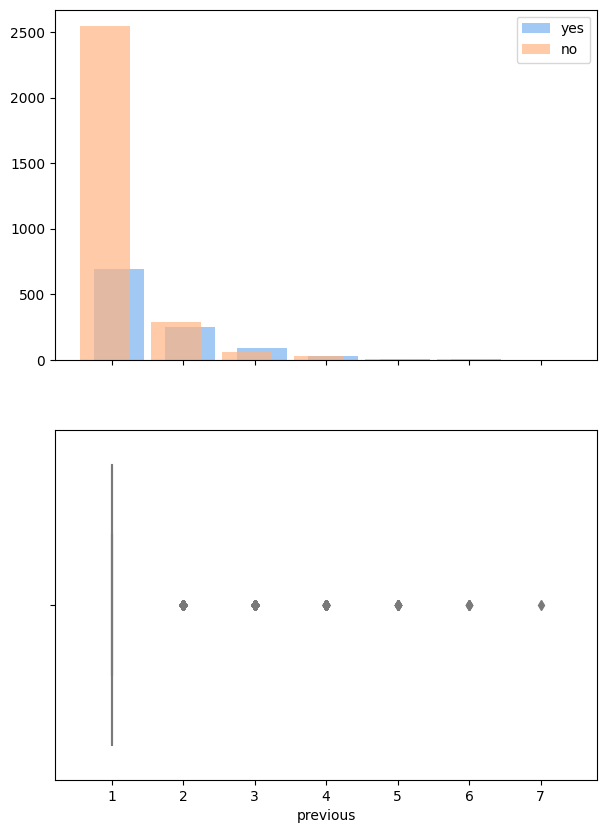

In [101]:
fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharex=True)
ct = pd.crosstab(df[df['previous'] > 0]['previous'], df['y']).sort_index(axis=0)
axs[0].bar(x=[x+1.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
axs[0].bar(x=[x+0.9 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
axs[0].set_xticks(range(1, 8))
axs[0].legend();

# boxplot of to detect outlier values (excluding value 0)
sns.boxplot(data=df[df['previous'] > 0], x='previous', ax=axs[1])
axs[1].set_xticklabels(range(1, 8));

So each value except 1 can be treated as outlier.  
Let's find out if we can use WOE approach here ((1) each category contains >5% of sample size and (2) each category contains positive and negative target values)

In [77]:
print('Total num of records: {}, category threshold size: {}'.format(len(df), np.ceil(0.05 * len(df))))
print('With `0` value excluded - total: {} , threshold size: {}'.format(len(df[df['previous'] > 0]), np.ceil(0.05*len(df[df['previous'] > 0]))))
df.groupby(by='previous')[['previous', 'y']].agg({'previous': ['count'], 'y': ['sum', 'mean']})

Total num of records: 28831, category threshold size: 1442.0
With `0` value excluded - total: 3993 , threshold size: 200.0


previous     y        
            count   sum    mean
previous                       
0           24838  2181  0.0878
1            3234   691  0.2137
2             534   246  0.4607
3             151    89  0.5894
4              56    30  0.5357
5              12     8  0.6667
6               5     3  0.6000
7               1     0  0.0000

Considering 3 as a cutoff value will provide necessary category threshold size > 200 after cutoff

In [78]:
# check predictive power for cutted-off feature based on WOE/IV
feature = 'previous'
print('Calculating prediction strength of features:')
print('Feature \tIV')
print('-'*20)
woe, iv = get_woe_cat(df[feature].apply(lambda x: np.min([x, 3])), df['y'], return_details=True)
print('{} \t{:.4f} ({})'.format(feature, iv, interpret_iv(iv)))
woe

Calculating prediction strength of features:
Feature 	IV
--------------------
previous 	0.3417 (strong)


,num_events,num_nonevents,num_cat_total,events_share,nonevents_share,woe,iv
feature,,,,,,,
0,2181,22657,24838,0.6715,0.8856,-0.2764,0.0592
1,691,2543,3234,0.2127,0.0994,0.7556,0.0856
2,246,288,534,0.0757,0.0113,1.8343,0.1183
3,130,95,225,0.0400,0.0037,2.1638,0.0786


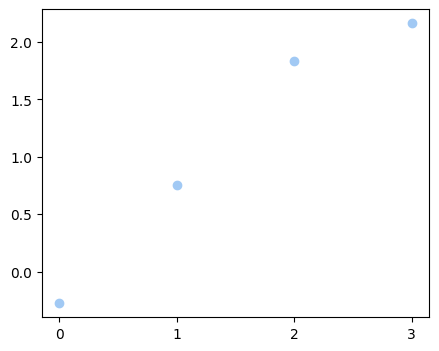

In [79]:
# check monotonity
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(x=range(len(woe)), y=woe['woe'])
ax.set_xticks(range(len(woe)))
ax.set_xticklabels([str(x) for x in woe.index]);

In [80]:
m = df['previous'] > 3
df.loc[m, 'previous']

72       5
605      4
686      4
1220     5
1376     4
        ..
26896    4
27035    5
27397    4
28124    4
28508    4
Name: previous, Length: 74, dtype: int64

In [81]:
# performing real cutoff
df['previous'] = df['previous'].apply(lambda x: np.min([x, 3]))
df.loc[m, 'previous']

72       3
605      3
686      3
1220     3
1376     3
        ..
26896    3
27035    3
27397    3
28124    3
28508    3
Name: previous, Length: 74, dtype: int32

[PIPELINE] We can test the same transformation type for `previous` feature as for `pdays`: leave out 0 value and encode groups '1', '2' and '>=3'

#### 9.3. Exploring `poutcome` feature

In [82]:
df['poutcome'].value_counts()

nonexistent    24838
failure         3003
success          990
Name: poutcome, dtype: int64

In [83]:
# check predictive power
feature = 'poutcome'
woe, iv = get_woe_cat(df[feature], df['y'])
print('Information Value: {:.4f} ({})'.format(iv, interpret_iv(iv)))
woe

Information Value: 0.5355 (suspicious)


feature
failure        0.2805
nonexistent   -0.2764
success        2.5767
Name: woe, dtype: float64

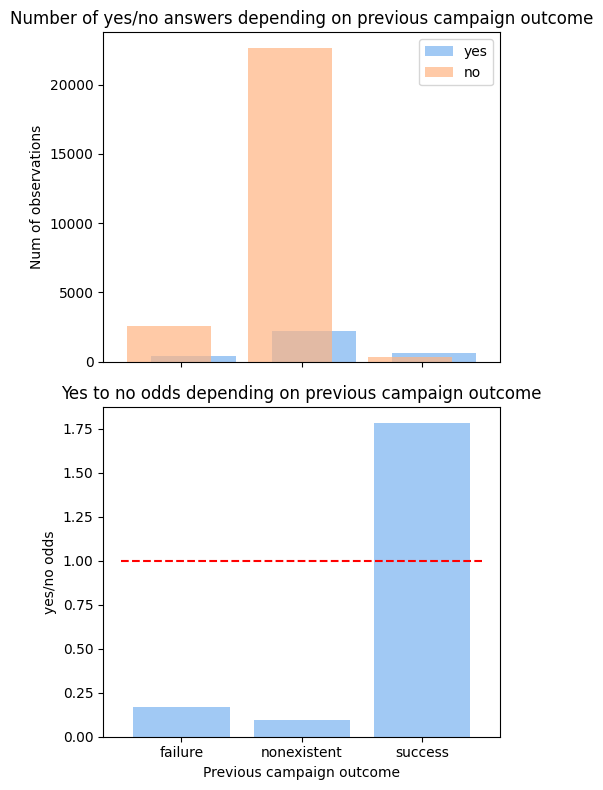

In [114]:
ct = pd.crosstab(df['poutcome'], df['y'])

fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
axs[0].bar(x=[x+0.1 for x in range(len(ct.index))], height=ct[target_positive], width=0.7, label='yes')
axs[0].bar(x=[x-0.1 for x in range(len(ct.index))], height=ct[target_negative], width=0.7, alpha=0.7, label='no')
axs[0].set_xticks(range(len(ct)))
axs[0].set_xticklabels(ct.index)
axs[0].set_ylabel('Num of observations')
axs[0].legend()
axs[0].set_title('Number of yes/no answers depending on previous campaign outcome')

axs[1].bar(x=ct.index, height=ct[1]/ct[0])
axs[1].plot([-0.5, 2.5], [1, 1], 'r--')
axs[1].set_xlabel('Previous campaign outcome')
axs[1].set_ylabel('yes/no odds')
axs[1].set_title('Yes to no odds depending on previous campaign outcome')

fig.tight_layout();

Negative / positive target ratio for each feature's value shows that this feature could be a useful predictor in case customer was contacted in previous marketing campaign

In [85]:
prev_campaign_ratio = pd.crosstab(df['poutcome'], df['previous'])
prev_campaign_ratio

previous,0,1,2,3
poutcome,,,,
failure,0,2610,310,83
nonexistent,24838,0,0,0
success,0,624,224,142


Comparing if previous campaign effectiveness is similar with last campaign depending on `previous` feature value

In [86]:
print('Campaigns effectiveness comparing (success/failure ratio):')
print('Num \tPrev \tLast')
for i in range(1, len(prev_campaign_ratio.columns)):
    prev_ratio = (prev_campaign_ratio.loc['success', i]) / (prev_campaign_ratio.loc['failure', i])
    last_ratio = len(df[(df['y'] == target_positive) & (df['previous'] == i)]) / len(df[(df['y'] == target_negative) & (df['previous'] == i)])
    print('{} \t{:.2f} \t{:.2f}'.format(i, prev_ratio, last_ratio))

Campaigns effectiveness comparing (success/failure ratio):
Num 	Prev 	Last
1 	0.24 	0.27
2 	0.72 	0.85
3 	1.71 	1.37


Success rate for the previous campaign is similar to last campaign => poutcome might be a good predictor for values  
[PIPELINE]  
Replace values by WoE estimates

[NOTE] THINK ABOUT ENCODING: test similar to WoE values to predict. 'nonexistent' value can be equivalent to success / failure ratio of the previous marketing campaign = 1 (50/50, unknown), <1 = more failure, >1 = more success  

### 10. Drop `duration` feature

In [87]:
df = df.drop(columns='duration')

## Final look of the dataset

In [88]:
# check if missing-like values remained
print(f'Calculating real NaNs ratio using `{cat_nan_equiv}` and `{num_nan_equiv}` keyvalues:')
print('Column (value) \tNvalues \tRatio')
print('-'*40)
for col in df.columns:
    if df[col].dtype == 'object':
        nan_equiv = cat_nan_equiv
    else:
        nan_equiv = num_nan_equiv
    if nan_equiv in list(df[col]):
        freq_table = df[col].value_counts()
        print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------


There is no missing-like values in dataset. So it can be used to encode features and train model

In [89]:
df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_ordered,age_bins
5514,28,services,married,high.school,0.1503,yes,no,0.0,may,mon,1.0,-0.223,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,high.school,"(25, 35]"
8652,30,technician,married,university.degree,0.1503,no,yes,1.0,jun,fri,1.0,-0.223,1,failure,-1.7,94.055,-39.8,0.748,4991.6,0,university.degree,"(25, 35]"
310,44,technician,divorced,university.degree,-0.8191,no,no,1.0,aug,tue,1.0,-0.223,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,0,university.degree,"(35, 45]"
13030,51,entrepreneur,married,professional.course,-0.8191,no,no,1.0,may,mon,1.0,-0.223,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,0,professional.course,"(45, 55]"
27914,32,admin.,single,university.degree,0.1503,no,no,0.0,may,tue,1.0,-0.223,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,university.degree,"(25, 35]"
6043,43,admin.,married,university.degree,0.1503,yes,yes,1.0,jul,wed,1.0,-0.223,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0,university.degree,"(35, 45]"
983,38,blue-collar,married,basic.4y,0.1503,yes,no,1.0,nov,mon,2.0,-0.223,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0,basic.4y,"(35, 45]"
23782,28,admin.,single,high.school,0.1503,yes,no,1.0,mar,thu,4.0,-0.223,0,nonexistent,-1.8,92.843,-50.0,1.538,5099.1,0,high.school,"(25, 35]"
593,33,admin.,married,high.school,0.1503,yes,no,0.0,jun,tue,1.0,-0.223,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,0,high.school,"(25, 35]"
1123,43,admin.,married,high.school,0.1503,yes,no,1.0,may,fri,1.0,-0.223,1,failure,-1.8,92.893,-46.2,1.250,5099.1,0,high.school,"(35, 45]"


In [90]:
df.shape

(28831, 22)

In [91]:
export_filename = import_filename.split('.')[0] + '_cleaned.csv'
df.to_csv(export_filename)

Based on the Weight of Evidence approach the predictive powers of features were evaluated.
All features were left except ‘duration’.  
Dataset is highly imbalanced so missing-like data was retained to encode it later.  
3 highly correlated features found. They are 'euribor3m', 'nr.employed' and 'emp.var.rate' (Pearson’s r > 0.9). This is a potential problem for some ML model types.

Final recommendations:
-	Perform features encoding using 3 main strategies (and their mixed options with dropping any of high correlated and/or low variance features) and compare their impact on model’s metrics:
    - use WoE approach to encode all category and category-like features without imputation
    - use WoE partially only on truly categorical features without imputation, numeric features convert to reasonable values and cutoff outlying values
    - don’t use WoE on any feature, impute values and encode categorical features by  ordinary way
-	As the problem is of binary classification class and has to be a relatively interpretable we can try Logistic Regression, Bayes Naïve Classifier, Decision Tree, Random Forest and LightGBM / CatBoost (with SHAP explanation) classes
